# Weighted Network Analysis

With this notebook I provide an analysis of the weighted network contained in the file **weighted_academic_graph.txt**
. In this network, each node represents a State, while an edge between two nodes represents the movement of a 
researcher from an institution to another. Both the nodes and the edges are enriched with some data, in particular, 
each node contains the **name** of the State it represents, while each edge contains the **year** of the movement and
a **weight** parameter. The weight parameter is used for keeping track of the number of times the researcher moved
from a State to another during the year represented by the year parameter. 

## Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from collections import Counter
from tqdm import tqdm

%matplotlib inline

## Importing & Building the Network

I decided to represent the network as a **multi directed weighted network**, using as weight for each edge the number 
of times a researcher moves between two States during the same year, as provided by the dataset.

In [2]:
weighted_network = nx.MultiDiGraph()

weighted_net_df = pd.read_csv('../../datasets/in/weighted_academic_graph.txt',
                              sep='\t', names=['from', 'to', 'year', 'weight'],
                              dtype={'from': str, 'to': str, 'year': int,
                                     'weight': int})

print('\n{}\n'.format(weighted_net_df.info()))

states = sorted(set(weighted_net_df['from']).union(set(weighted_net_df['to'])))
mapping = dict()

for index, state in enumerate(states):
    mapping[state] = index

for state in tqdm(states, desc='ADDING NODES'):
    weighted_network.add_node(mapping[state], state=state)

for row in tqdm(weighted_net_df.itertuples(index=False),
                desc='CONNECTING NODES', total=96185):
    weighted_network.add_edge(mapping[getattr(row, '_0')],
                              mapping[getattr(row, 'to')],
                              year=getattr(row, 'year'),
                              weight=getattr(row, 'weight'))

CONNECTING NODES:  15%|█▌        | 14487/96185 [00:00<00:00, 144864.61it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96185 entries, 0 to 96184
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   from    96185 non-null  object
 1   to      96185 non-null  object
 2   year    96185 non-null  int64 
 3   weight  96185 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.9+ MB

None



CONNECTING NODES: 100%|██████████| 96185/96185 [00:00<00:00, 152065.43it/s]


## Number of Nodes, Edges and Selfloops

In [3]:
print('\nNODES: {}, EDGES: {}\n'.format(weighted_network.number_of_nodes(),
                                        weighted_network.number_of_edges()))

print('NUMBER OF SELFLOOPS: {}\n'
      .format(len([e for e in weighted_network.edges() if e[0] == e[1]])))


NODES: 184, EDGES: 96185

NUMBER OF SELFLOOPS: 0



## Network's representation

For this visualization I decided to scale the network's node depending on their incoming degree, that is, 
representing nodes with an high incoming degree as bigger nodes and nodes with small incoming degree as smaller 
ones. The scale I used is a **linear** one, that is, it is the direct translation of the incoming degree of a node
into its scale value. Using this type of scaling, if, for e.g., we have a node with incoming degree 5 we will have
a scaling value of 5 for that node.

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

pos = nx.spring_layout(weighted_network, k=2.5)

nx.draw_networkx_nodes(weighted_network, pos=pos,
                       nodelist=dict(weighted_network.in_degree()).keys(),
                       node_size=[in_d * 1 for in_d in
                                  dict(weighted_network.in_degree()).values()],
                       alpha=0.5, ax=axs, node_color='#3296dc', 
                       edgecolors='#1f77b4')
nx.draw_networkx_edges(weighted_network, pos, width=0.5, arrowsize=7,
                       alpha=0.1, ax=axs)

labels = dict()
for n in weighted_network.nodes(data=True):
    labels[n[0]] = n[1]['state']
nx.draw_networkx_labels(weighted_network, pos, labels, font_size=3,
                        font_color='#ff4d4d', ax=axs)

fig.suptitle('Weighted Network', fontsize=20)
axs.set_title("The Nodes' sizes correspond to their Incoming Degrees",
             fontsize=14)
fig.savefig('./images/graph.pdf', format='pdf')

# Degree distribution

In order to study the degree distribution for the weighted network, I decided to plot the degrees, incoming 
degrees and outgoing degrees of the network's nodes both as histograms and scatterplots. The plots show two
slightly different approaches to visualize the probability density fuction for the network's nodes degrees, 
incoming degrees and outgoing degrees.

NODES WITH MAX DEGREE: ['United States'], NODES WITH MIN DEGREE: ['Aruba', 'Guinea']
NODES WITH MAX IN DEGREE: ['United States'], NODES WITH MIN DEGREE: ['Aruba']
NODES WITH MAX OUT DEGREE: ['United States'], NODES WITH MIN DEGREE: ['Guinea', 'Saint Lucia']


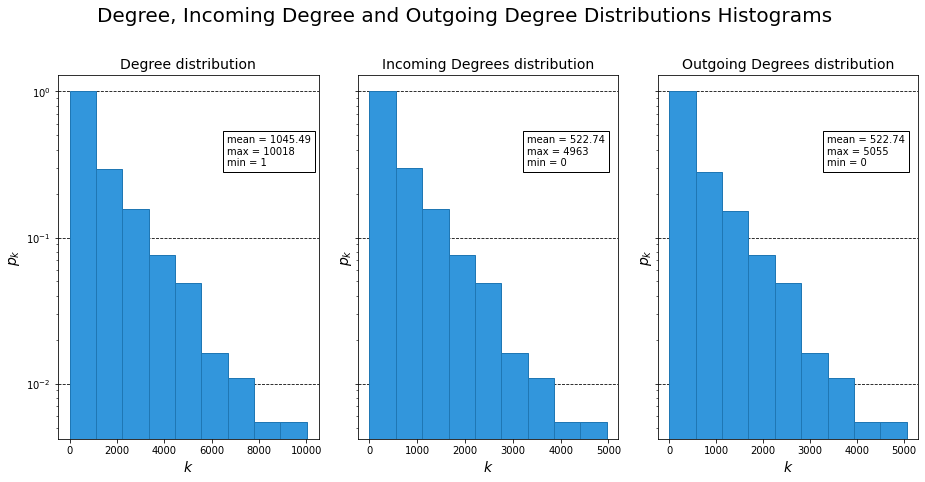

In [4]:
degree = sorted([d for n, d in weighted_network.degree()])
in_degree = sorted([d for n, d in weighted_network.in_degree()])
out_degree = sorted([d for n, d in weighted_network.out_degree()])

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(13, 7))
fig.suptitle(
    'Degree, Incoming Degree and Outgoing Degree Distributions Histograms', 
    fontsize=20)

for i, d in enumerate([degree, in_degree, out_degree]):
    title, d_type = None, None
    max_d, min_d = max(d), min(d)
    max_nodes, min_nodes = list(), list()

    if i == 0:
        title = 'Degree distribution'
        d_type = 'DEGREE'
        max_nodes = [d['state'] for n, d in weighted_network.nodes(data=True)
                     if weighted_network.degree(n) == max_d]
        min_nodes = [d['state'] for n, d in weighted_network.nodes(data=True)
                     if weighted_network.degree(n) == min_d]
    elif i == 1:
        title = 'Incoming Degrees distribution'
        d_type = 'IN DEGREE'
        max_nodes = [d['state'] for n, d in weighted_network.nodes(data=True)
                     if weighted_network.in_degree(n) == max_d]
        min_nodes = [d['state'] for n, d in weighted_network.nodes(data=True)
                     if weighted_network.in_degree(n) == min_d]
    else:
        title = 'Outgoing Degrees distribution'
        d_type = 'OUT DEGREE'
        max_nodes = [d['state'] for n, d in weighted_network.nodes(data=True)
                     if weighted_network.out_degree(n) == max_d]
        min_nodes = [d['state'] for n, d in weighted_network.nodes(data=True)
                     if weighted_network.out_degree(n) == min_d]

    print('NODES WITH MAX {}: {}, NODES WITH MIN DEGREE: {}'
          .format(d_type, max_nodes, min_nodes))

    axs[i].hist(d, bins='sturges', density='True', cumulative=-1, log=True,
               zorder=2, color='#3296dc', edgecolor='#1f77b4')
    axs[i].set_title(title, fontsize=14)
    axs[i].set_xlabel(r'$k$', fontsize=14)
    axs[i].set_ylabel(r'$p_k$', fontsize=14)
    axs[i].grid(axis='y', linestyle='--', color='black', zorder=1)
    axs[i].text(0.65, 0.75, 'mean = {}\nmax = {}\nmin = {}'
                .format(round(np.mean(d), 2), max(d), min(d)),
               bbox=dict(facecolor='white', edgecolor='black'),
               transform=axs[i].transAxes)

fig.tight_layout(rect=[0, 0.03, 1, 0.90])

fig.savefig('./images/degrees_distributions.pdf', format='pdf', 
            bbox_inches='tight')

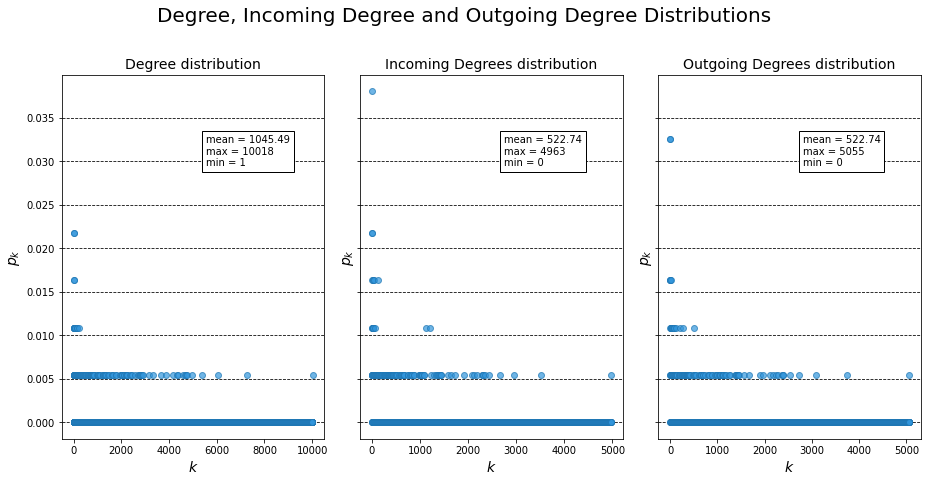

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True,figsize=(13, 7))
fig.suptitle('Degree, Incoming Degree and Outgoing Degree Distributions', 
    fontsize=20)

for i, d in enumerate([degree, in_degree, out_degree]):
    title = None

    if i == 0:
        title = 'Degree distribution'
    elif i == 1:
        title = 'Incoming Degrees distribution'
    else:
        title = 'Outgoing Degrees distribution'
    
    c, countdict_pdf = Counter(d), dict()
    
    for deg in np.arange(min(d), max(d) + 1):
        countdict_pdf[deg] = (c[deg] / len(d)) if deg in c.keys() else 0.

    axs[i].scatter(list(countdict_pdf.keys()), list(countdict_pdf.values()),
                   zorder=2, alpha=0.7,color='#3296dc', edgecolor='#1f77b4')
    axs[i].set_title(title, fontsize=14)
    axs[i].set_xlabel(r'$k$', fontsize=14)
    axs[i].set_ylabel(r'$p_k$', fontsize=14)
    axs[i].grid(axis='y', linestyle='--', color='black', zorder=1)
    axs[i].text(0.55, 0.75, 'mean = {}\nmax = {}\nmin = {}'
                .format(round(np.mean(d), 2), max(d), min(d)),
               bbox=dict(facecolor='white', edgecolor='black'),
               transform=axs[i].transAxes)

fig.tight_layout(rect=[0, 0.03, 1, 0.90])

fig.savefig('./images/degrees_distributions_scatter.pdf', format='pdf', 
            bbox_inches='tight')

As we can see, by observing this two types of visualization, we can conclude that the weighted network is, in 
fact, a **scale-free network**, that is, a network in which the majority of nodes have small degrees, while a 
small subset of nodes have high degrees.

# CONNECTEDNESS

By studying the network's connectedness we discover that the network is not strongly connected. However, by 
relaxing the constraint, we discover that the network is weakly connected with 1 connected component that 
contains all the network's nodes.

In [6]:
if nx.is_weakly_connected(weighted_network):
    if nx.is_strongly_connected(weighted_network):
        cc = nx.number_strongly_connected_components(weighted_network)

        print('\nTHE NETWORK IS STRONGLY CONNECTED WITH {} '
              'CONNECTED COMPONENT(S)'.format(cc))
    else:
        cc = nx.number_weakly_connected_components(weighted_network)

        print('\nTHE NETWORK IS WEAKLY CONNECTED WITH {} '
              'CONNECTED COMPONENT(S)'.format(cc))


THE NETWORK IS WEAKLY CONNECTED WITH 1 CONNECTED COMPONENT(S)


# CLUSTERING COEFFICIENT

Since the network is multi directed, we can not directly study the clustering coefficient for its nodes. In order
to circumvent this problem I modified the network's structure by condensing its edges. The edges of the 
**condensed network** represent one or more edges of the original one, so if, for e.g., in the original network
there are three distinct edges connecting a node to another, in the condensed one there will be only one edge
which contains the data of the three distinct edges.

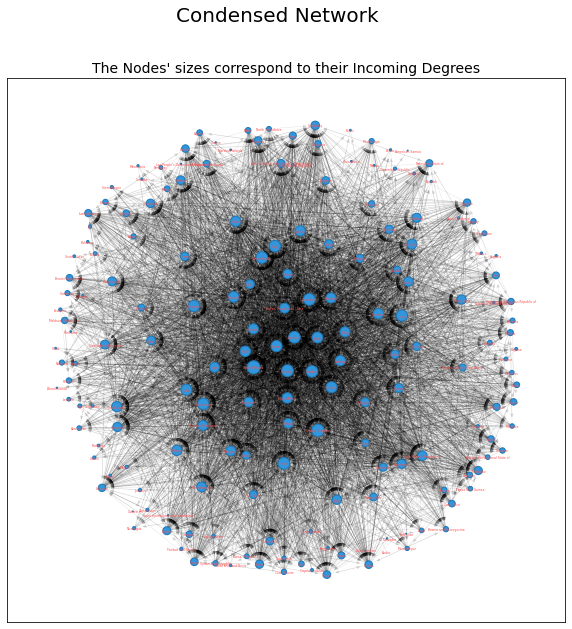

In [7]:
weighted_network_digraph = nx.DiGraph()

for state in states:
    weighted_network_digraph.add_node(mapping[state], state=state)

for n_1 in weighted_network.nodes():
    for n_2 in weighted_network.nodes():
        data = None

        if weighted_network.has_edge(n_1, n_2):
            data = [e[2] for e in weighted_network.edges(n_1, data=True)
                    if e[1] == n_2]

            weighted_network_digraph.add_edge(n_1, n_2, data=data)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

pos = nx.spring_layout(weighted_network_digraph, k=2.5)

nx.draw_networkx_nodes(weighted_network_digraph, pos,
                       nodelist=dict(weighted_network_digraph.in_degree()).
                       keys(),
                       node_size=[in_d * 1 for in_d in
                                  dict(weighted_network_digraph.in_degree()).
                                  values()], ax=axs, node_color='#3296dc',
                      edgecolors='#1f77b4')
nx.draw_networkx_edges(weighted_network_digraph, pos, width=0.5, arrowsize=7,
                       alpha=0.1, ax=axs)

labels = dict()
for n in weighted_network_digraph.nodes(data=True):
    labels[n[0]] = n[1]['state']
nx.draw_networkx_labels(weighted_network_digraph, pos, labels, font_size=3,
                        font_color='#ff4d4d', ax=axs)

fig.suptitle('Condensed Network', fontsize=20)
axs.set_title("The Nodes' sizes correspond to their Incoming Degrees",
             fontsize=14)
fig.savefig('./images/graph_condensed.pdf', format='pdf')

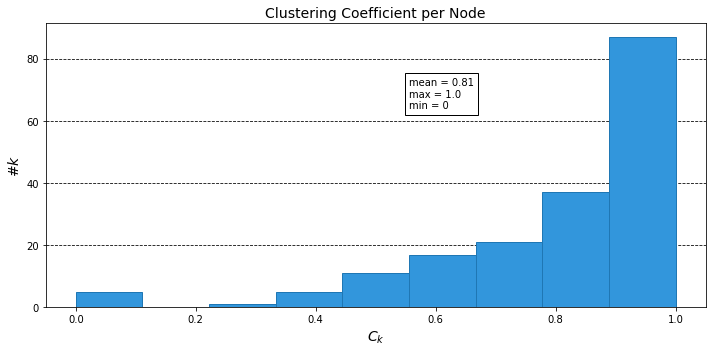

In [8]:
ccs = nx.clustering(weighted_network_digraph).values()
mean_cc = np.round(nx.average_clustering(weighted_network_digraph), 2)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axs.hist(ccs, bins='sturges', zorder=2, color='#3296dc', edgecolor='#1f77b4')
axs.text(0.55, 0.70, 'mean = {}\nmax = {}\nmin = {}'
         .format(mean_cc, max(list(ccs)), min(list(ccs))),
         bbox = dict(facecolor='white', edgecolor='black'),
         transform = axs.transAxes)
axs.set_title('Clustering Coefficient per Node', fontsize = 14)
axs.set_xlabel(r'$C_k$', fontsize = 14)
axs.set_ylabel(r'$\# k$', fontsize = 14)
axs.grid(axis = 'y', linestyle = '--', color = 'black', zorder = 1)

fig.tight_layout()
fig.savefig('./images/clustering_coefficient.pdf', format = 'pdf',
            bbox_inches='tight')

# SHORTEST PATHS

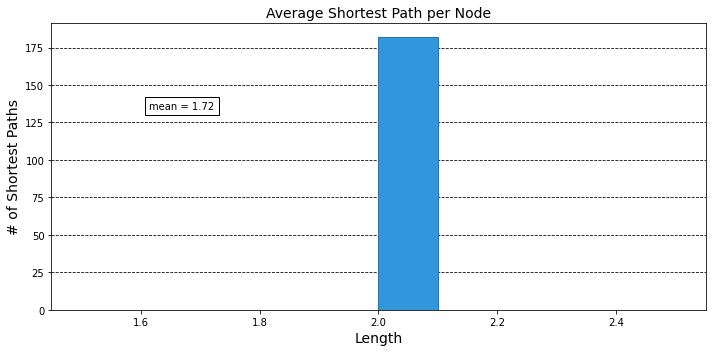

In [9]:
paths = nx.shortest_path(weighted_network)
avg_sp_per_node = dict()

for n_1 in weighted_network.nodes():
    avg_sp_per_node[n_1] = list()

    for edge in weighted_network.edges([n_1]):
        if edge not in avg_sp_per_node[n_1]:
            avg_sp_per_node[n_1].append(edge)

    lengths = [len(paths[e[0]][e[1]]) for e in avg_sp_per_node[n_1]]

    if len(lengths) == 0:
        del avg_sp_per_node[n_1]
    else:
        avg_sp_per_node[n_1] = np.mean(lengths)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axs.hist(avg_sp_per_node.values(), zorder=2, color='#3296dc', 
         edgecolor='#1f77b4')
axs.text(0.15, 0.70, 'mean = {}'
         .format(np.round(nx.average_shortest_path_length(weighted_network), 2)),
         bbox = dict(facecolor='white', edgecolor='black'),
         transform = axs.transAxes)
axs.set_title('Average Shortest Path per Node', fontsize=14)
axs.set_xlabel(r'Length', fontsize=14)
axs.set_ylabel(r'# of Shortest Paths', fontsize=14)
axs.grid(axis='y', linestyle='--', color='black', zorder=1)

fig.tight_layout()
fig.savefig('./images/avg_shortest_paths.pdf', format='pdf', 
            bbox_inches='tight')